In [1]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [2]:
 # Image dimensions
img_height, img_width = 180, 180
batch_size = 32

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=1,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.1,
                    horizontal_flip=False,
                    fill_mode='nearest')

# Just normalization for validation and testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the disk, applies data augmentation, and resizes the images
train_generator = train_datagen.flow_from_directory(
                    directory='./images/train',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    class_mode='binary')

val_generator = val_test_datagen.flow_from_directory(
                    directory='./images/val',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    class_mode='binary')

test_generator = val_test_datagen.flow_from_directory(
                    directory='./images/test',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Display Original Image

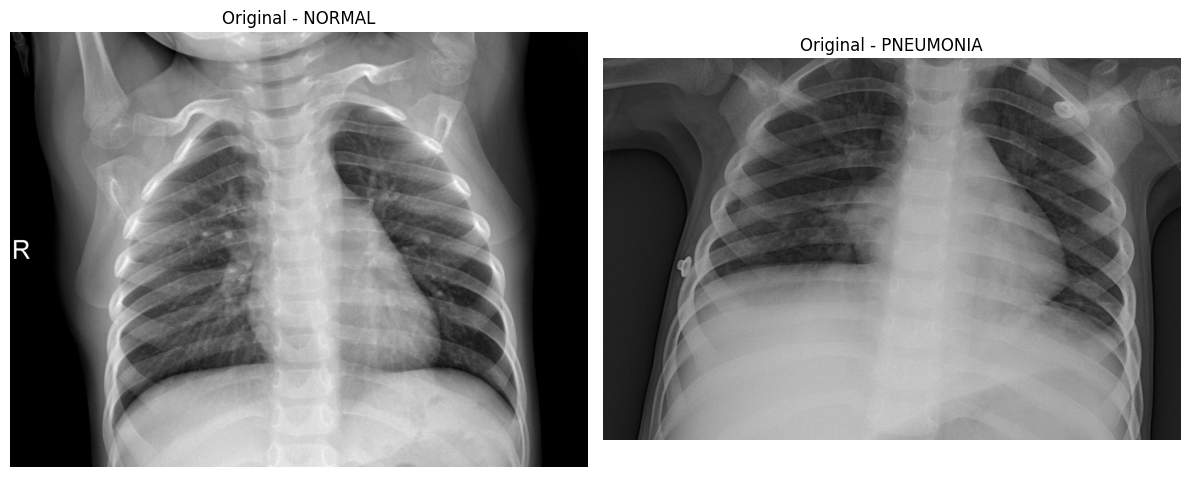

In [3]:
# Getting the filenames from the generator
fnames = train_generator.filenames

# Getting a random normal and pneumonia image paths
normal_img = [os.path.join('./images/train/', fname) for fname in fnames if 'NORMAL' in fname]
pneumonia_img = [os.path.join('./images/train/', fname) for fname in fnames if 'PNEUMONIA' in fname]

# Set the seed value
np.random.seed(2)
# Randomly selecting an image path
selected_normal = np.random.choice(normal_img)
selected_pneumonia = np.random.choice(pneumonia_img)

# Displaying the images
img_normal = mpimg.imread(selected_normal)
img_pneumonia = mpimg.imread(selected_pneumonia)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_normal, cmap='gray')
plt.title('Original - NORMAL')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_pneumonia, cmap='gray')
plt.title('Original - PNEUMONIA')
plt.axis('off')
plt.tight_layout()
plt.show()


## Display Proportion of Image

Total number of normal images: 1583
Total number of pneumonia images: 4273


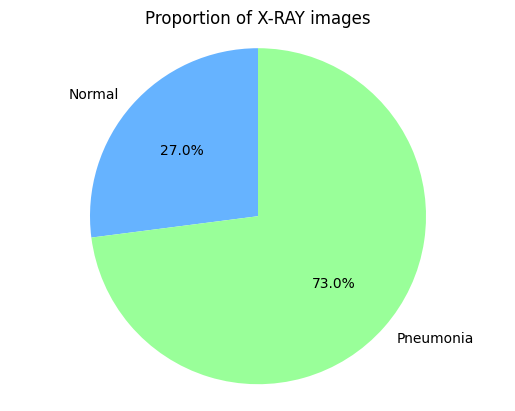

In [4]:
# Calculate number of normal and pneumonia images in training, validation and testing generators
def count_images(generator):
    count_normal = sum(1 for label in generator.classes if label == 0) # assuming normal class is labeled as 0
    count_pneumonia = sum(1 for label in generator.classes if label == 1) # assuming pneumonia class is labeled as 1
    return count_normal, count_pneumonia

# Calculate for train, test, val
train_normal, train_pneumonia = count_images(train_generator)
test_normal, test_pneumonia = count_images(test_generator)
val_normal, val_pneumonia = count_images(val_generator)

# Calculate total
total_normal = train_normal + test_normal + val_normal
total_pneumonia = train_pneumonia + test_pneumonia + val_pneumonia

print(f"Total number of normal images: {total_normal}")
print(f"Total number of pneumonia images: {total_pneumonia}")

# Plot the proportions
labels = ['Normal', 'Pneumonia']
sizes = [total_normal, total_pneumonia]
colors = ['#66b3ff','#99ff99']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('Proportion of X-RAY images')
plt.show()

# Image Pre Processing

## Image Sharpening

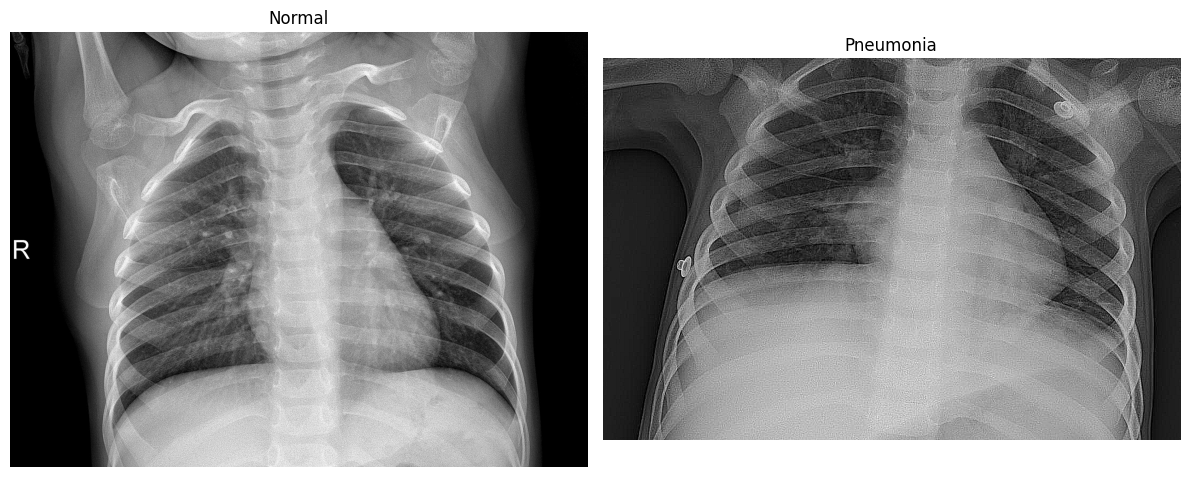

In [5]:
# Define the sharpening filter
filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

# Load the images
img_normal = cv2.imread(selected_normal)
img_pneumonia = cv2.imread(selected_pneumonia)

# Convert the images to grayscale (necessary for the filter)
img_normal_gray = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY)
img_pneumonia_gray = cv2.cvtColor(img_pneumonia, cv2.COLOR_BGR2GRAY)

# Apply the sharpening filter
img_normal_sharp = cv2.filter2D(img_normal_gray, -1, filter)
img_pneumonia_sharp = cv2.filter2D(img_pneumonia_gray, -1, filter)

# Display the images
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_normal_sharp, cmap='gray')
plt.title('Normal')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_pneumonia_sharp, cmap='gray')
plt.title('Pneumonia')
plt.axis('off')
plt.tight_layout()
plt.show()

## Mean, Gaussian,and Edge Detection Filtering Techniques

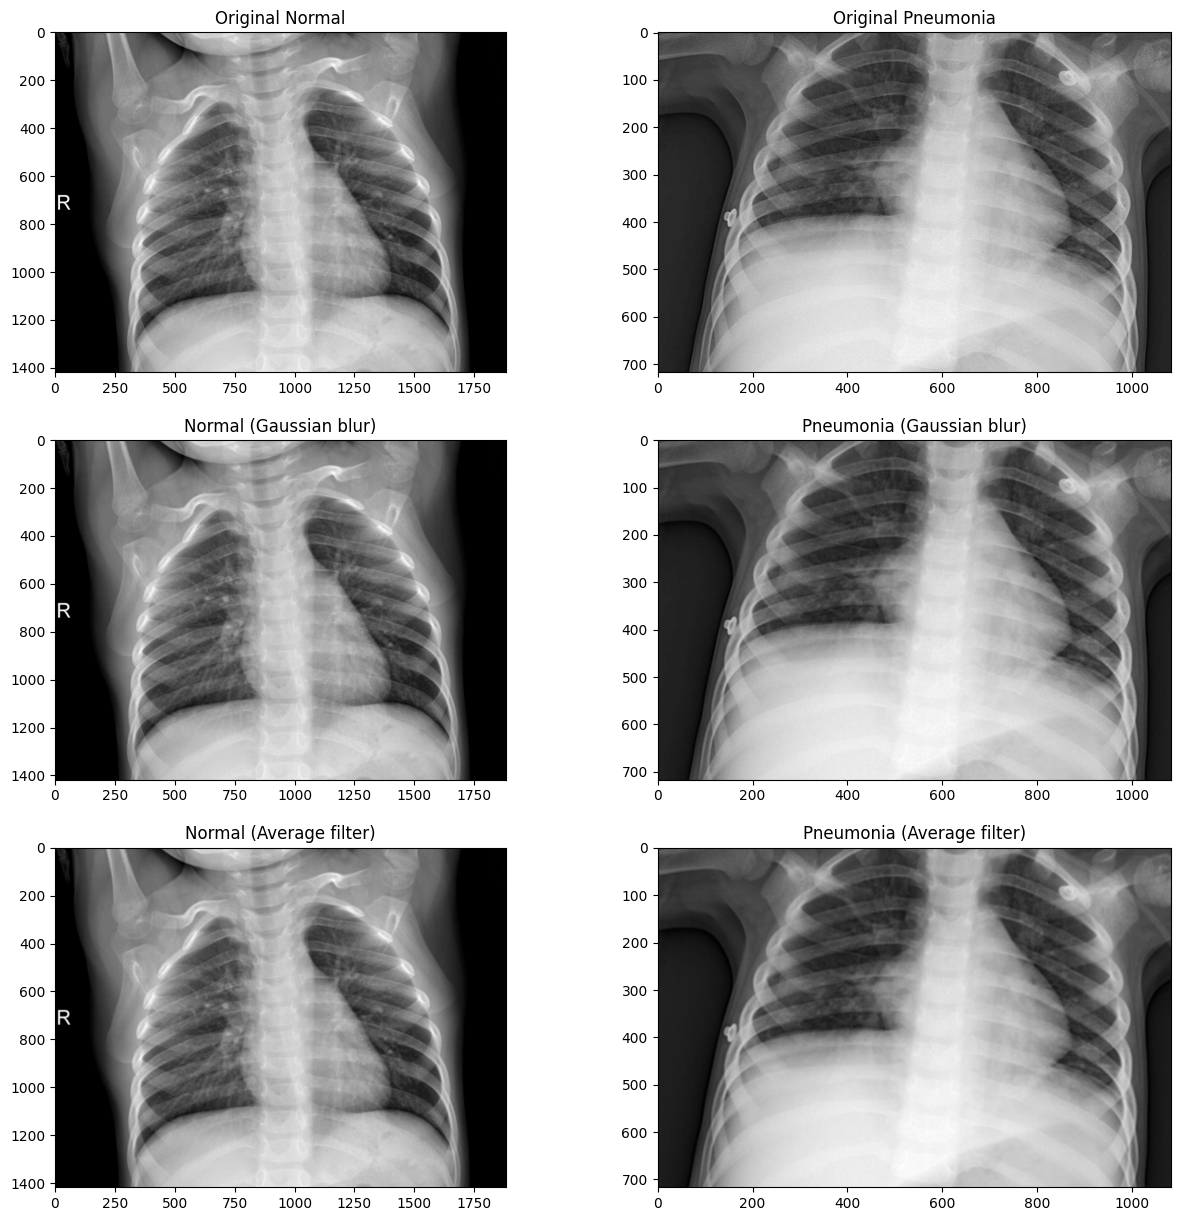

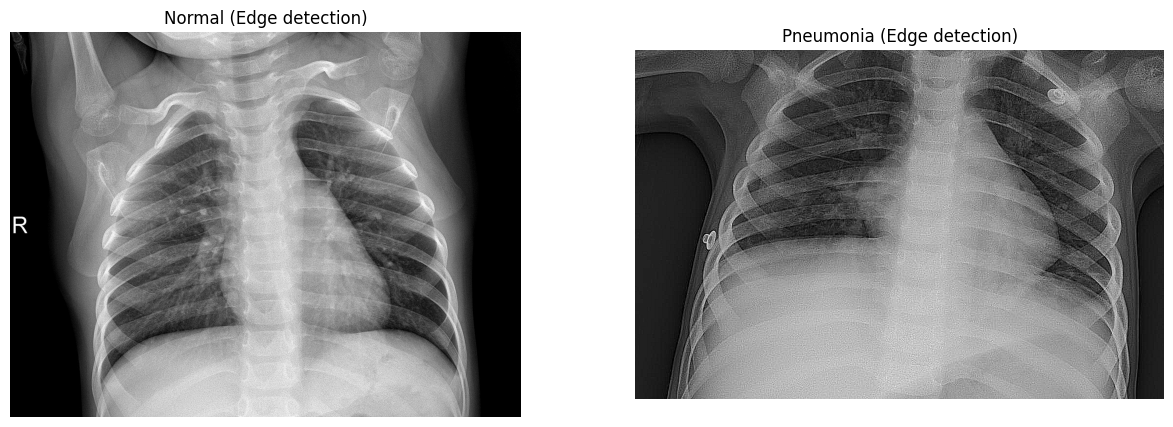

In [6]:
# Define filters
average_filter = np.ones((5, 5), np.float32)/25
edge_filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

# Load the images
img_normal = cv2.imread(selected_normal, cv2.IMREAD_GRAYSCALE)
img_pneumonia = cv2.imread(selected_pneumonia, cv2.IMREAD_GRAYSCALE)

# Apply the Gaussian blur
img_normal_blur = cv2.GaussianBlur(img_normal, (5, 5), 0)
img_pneumonia_blur = cv2.GaussianBlur(img_pneumonia, (5, 5), 0)

# Apply the average filter
img_normal_average = cv2.filter2D(img_normal, -1, average_filter)
img_pneumonia_average = cv2.filter2D(img_pneumonia, -1, average_filter)

# Apply the edge detection filter
img_normal_edge = cv2.filter2D(img_normal, -1, edge_filter)
img_pneumonia_edge = cv2.filter2D(img_pneumonia, -1, edge_filter)

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(15,15))

# Original images
axs[0, 0].imshow(img_normal, cmap='gray')
axs[0, 0].title.set_text('Original Normal')
axs[0, 1].imshow(img_pneumonia, cmap='gray')
axs[0, 1].title.set_text('Original Pneumonia')

# After Gaussian blur
axs[1, 0].imshow(img_normal_blur, cmap='gray')
axs[1, 0].title.set_text('Normal (Gaussian blur)')
axs[1, 1].imshow(img_pneumonia_blur, cmap='gray')
axs[1, 1].title.set_text('Pneumonia (Gaussian blur)')

# After average filtering
axs[2, 0].imshow(img_normal_average, cmap='gray')
axs[2, 0].title.set_text('Normal (Average filter)')
axs[2, 1].imshow(img_pneumonia_average, cmap='gray')
axs[2, 1].title.set_text('Pneumonia (Average filter)')

# Edge detection
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(img_normal_edge, cmap='gray')
axs[0].title.set_text('Normal (Edge detection)')
axs[1].imshow(img_pneumonia_edge, cmap='gray')
axs[1].title.set_text('Pneumonia (Edge detection)')

for ax in axs.flat:
    ax.axis('off')

plt.show()

# Implementation of Advanced Pre-Processing Techniques

In [7]:
# Define each preprocessing function:

def preprocess_hist_eq(image):
    # Histogram equalization
    return cv2.equalizeHist(image)

def preprocess_hist_eq_gauss(image):
    # Histogram equalization followed by Gaussian blur
    image = cv2.equalizeHist(image)
    return cv2.GaussianBlur(image, (5, 5), 0)

def preprocess_hist_eq_bilateral(image):
    # Histogram equalization followed by Bilateral filter
    image = cv2.equalizeHist(image)
    image=cv2.GaussianBlur(image, (5, 5), 0)
    return cv2.bilateralFilter(image, d=5, sigmaColor=75, sigmaSpace=75)

def preprocess_adaptive_masking(image):
    # Adaptive masking to remove diaphragm
    max_intensity = np.max(image)
    min_intensity = np.min(image)
    threshold = min_intensity + (max_intensity - min_intensity) / 2
    _, thresholded = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    morph_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, morph_elem)
    return cv2.bitwise_and(image, image, mask=closed)

def preprocess_adaptive_mask_hist_eq_gauss(image):
    # Adaptive masking followed by histogram equalization and Gaussian blur
    image = preprocess_adaptive_masking(image)
    image = cv2.equalizeHist(image)
    return cv2.GaussianBlur(image, (5, 5), 0)

# Display Results of Each Advancement of Pre-Processing

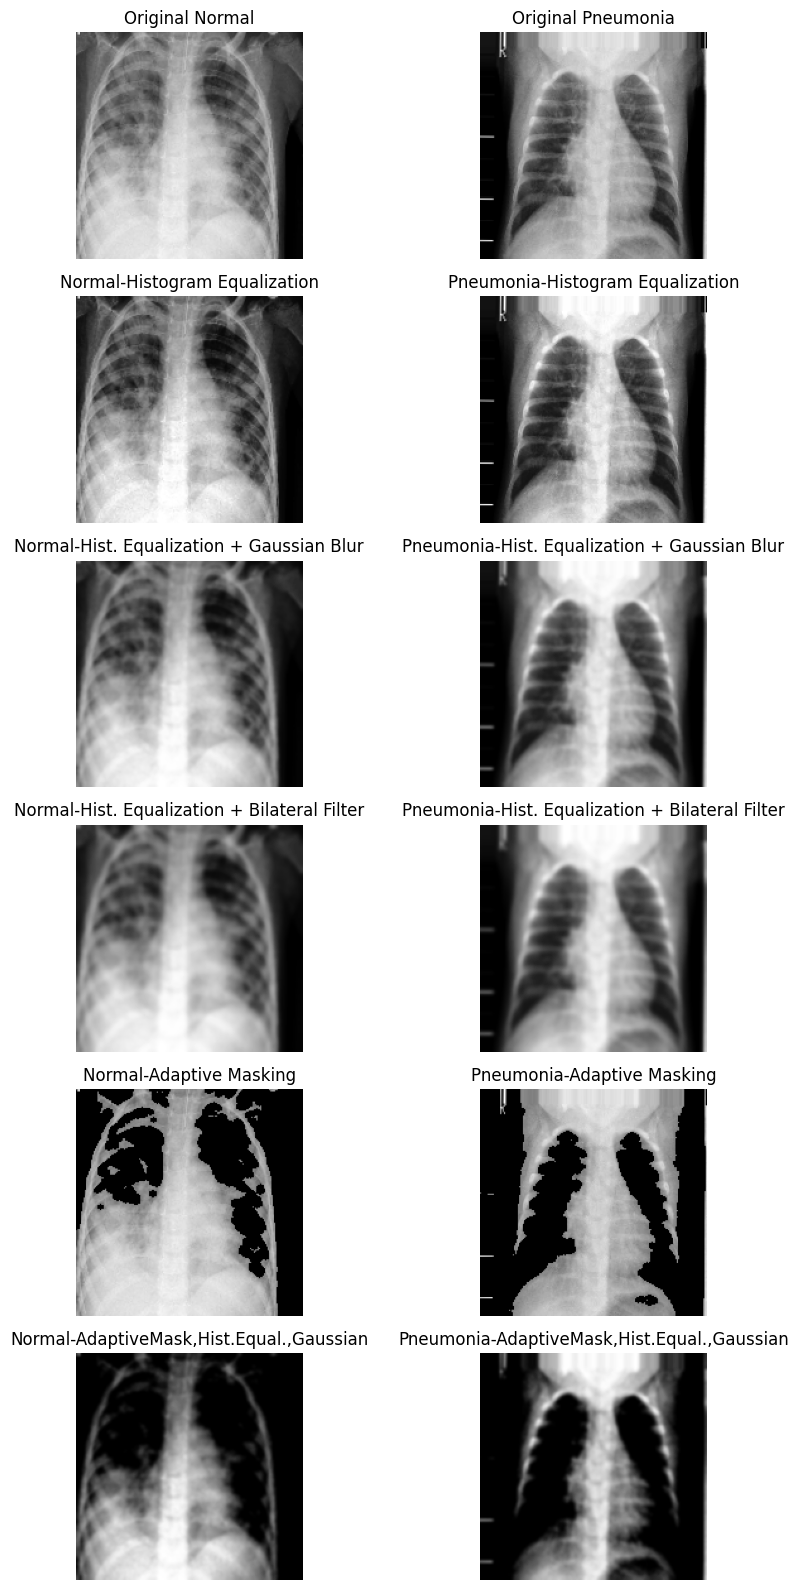

In [8]:
images, labels = next(train_generator)

# Select one Normal and one Pneumonia image from the batch
normal_image  =  cv2.cvtColor(images[0] , cv2.COLOR_BGR2GRAY)
pneumonia_image   =  cv2.cvtColor(images[1] , cv2.COLOR_BGR2GRAY)


# Ensure image is in the right format (8-bit)
normal_image= cv2.normalize(normal_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
pneumonia_image= cv2.normalize(pneumonia_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Apply each preprocessing technique and display the result
preprocessing_functions = [preprocess_hist_eq, preprocess_hist_eq_gauss, preprocess_hist_eq_bilateral, preprocess_adaptive_masking, preprocess_adaptive_mask_hist_eq_gauss]
preprocessing_names = ["Histogram Equalization", "Hist. Equalization + Gaussian Blur", 
                       "Hist. Equalization + Bilateral Filter", "Adaptive Masking", 
                       "AdaptiveMask,Hist.Equal.,Gaussian"]

fig, axs = plt.subplots(6, 2, figsize=(10, 16))

axs[0, 0].imshow(normal_image, cmap='gray')
axs[0, 0].set_title('Original Normal')
axs[0, 0].axis('off')

axs[0, 1].imshow(pneumonia_image, cmap='gray')
axs[0, 1].set_title('Original Pneumonia')
axs[0, 1].axis('off')

for i, (func, name) in enumerate(zip(preprocessing_functions, preprocessing_names)):
    normal_preprocessed = func(normal_image)
    pneumonia_preprocessed = func(pneumonia_image)
    
    axs[i+1, 0].imshow(normal_preprocessed, cmap='gray')
    axs[i+1, 0].set_title('Normal-'+name)
    axs[i+1, 0].axis('off')
    
    axs[i+1, 1].imshow(pneumonia_preprocessed, cmap='gray')
    axs[i+1, 1].set_title('Pneumonia-'+name)
    axs[i+1, 1].axis('off')
plt.tight_layout()
plt.show()

In [9]:
# Applying the final preprocessing technique to entire dataset
preprocessing_functions = [preprocess_hist_eq_bilateral]
preprocessing_names = ["Hist. Equalization + Bilateral Filter"]

# Apply preprocessing techniques to the entire sets of train, test, and validation images
def preprocess_dataset(generator):
    preprocessed_images = []
    labels = []
    for images, batch_labels in generator:
        for image, label in zip(images, batch_labels):
            image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            image_gray= cv2.normalize(image_gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            image_preprocessed = []
            for func in preprocessing_functions:
                preprocessed = func(image_gray)
                image_preprocessed.append(preprocessed)
            preprocessed_images.extend(image_preprocessed)
            labels.extend([label] * len(preprocessing_functions))
        if len(preprocessed_images) >= len(generator.filenames):
            break
    return np.array(preprocessed_images), np.array(labels)

x_train, y_train = preprocess_dataset(train_generator)
x_val, y_val = preprocess_dataset(val_generator)
x_test, y_test = preprocess_dataset(test_generator)

In [10]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Optimizer with learning rate decay
optimizer = Adam(learning_rate=0.001, decay=1e-6)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=50, 
                    validation_data=(x_val, y_val), 
                    callbacks=[early_stopping], verbose=0)

Final Training Accuracy: 0.9501533508300781
Final Validation Accuracy: 0.875
Number of Epochs: 25


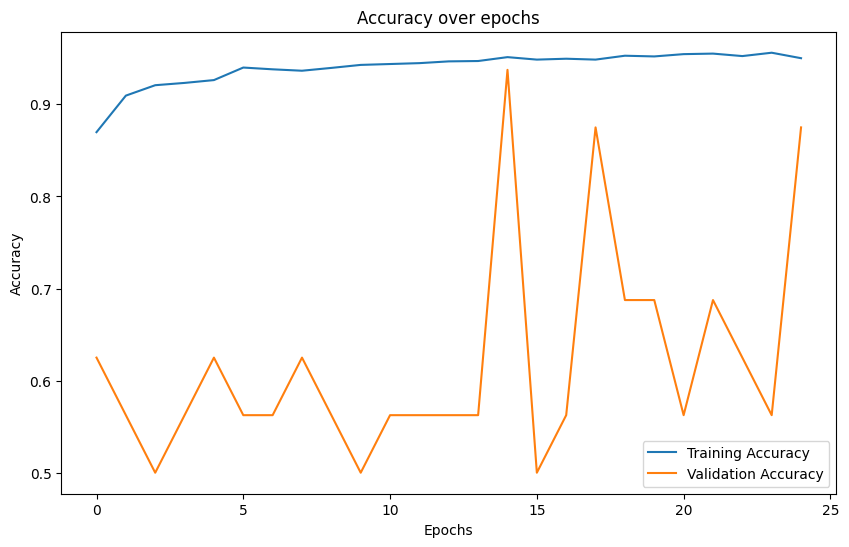

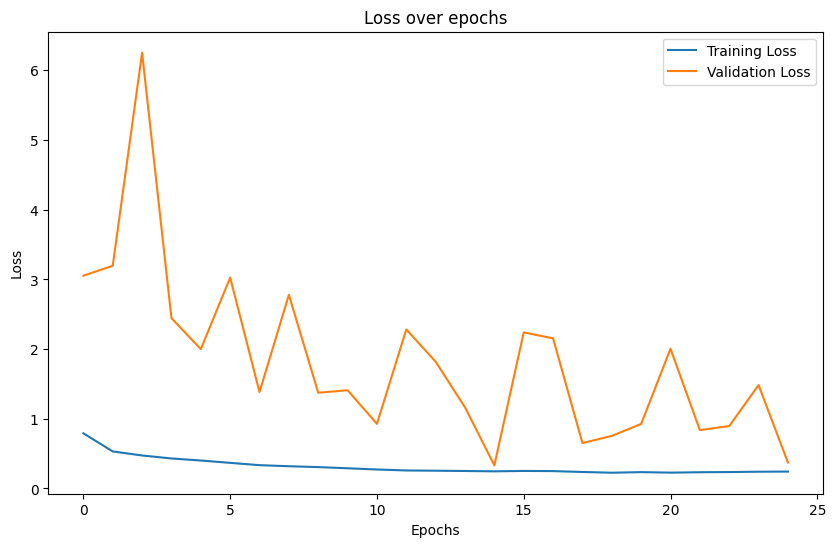

In [11]:
# Extract accuracy and loss from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print model accuracy and epoch
print("Final Training Accuracy:", train_acc[-1])
print("Final Validation Accuracy:", val_acc[-1])
print("Number of Epochs:", len(train_acc))

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Evaluate the model on the test set
test_loss, test_auc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test AUC:', test_auc)

20/20 [==============================] - 2s 105ms/step - loss: 0.5884 - accuracy: 0.8654
Test loss: 0.5883617401123047
Test AUC: 0.8653846383094788
